# Apophis Approach in 2029


This notebook contains all the required code to reproduce the results and figures in the paper:

- Vallejo, Zuluaga and Chaparro, Conditions for visual and high-resolution  bistatic radar observations of Apophis in 2029.

## Environment and preparation

This section is intended to prepare the execution environment.  If running in colab, and want to 

### Required packages

#Evaluate if we are in Colab
try:
    import google.colab
    COLAB = True
    python="python" # In colab
except:
    COLAB = False

import sys
python=sys.executable

# Install packages
!$python -m pip install astroquery cartopy

# Get complimentary data
if COLAB:
    !git clone http://github.com/seap-udea/Apophis2029.git
    !ln -s Apophis2029/data

### Libraries and useful routines

In [72]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime
import dateutil.parser as dparser

# Astropy
from astroquery.jplhorizons import Horizons
from astropy.time import Time
from astropy.table import Table
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_sun
import astropy.units as u
import astropy.constants as c

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import cm

# Figure Parameters
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 20
plt.rcParams['axes.linewidth'] = 2

#Constantes
DATADIR="data/"
FIGDIR="data/figures/"

#### Routines

In [97]:
def add_arrow(line, position=None, direction='right', size=15, color=None):
    """
    (Taken from https://coderedirect.com/questions/214576/arrow-on-a-line-plot-with-matplotlib)
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="-|>", color=color),
        size=size
    )

def rotation(ax,N,R,dth):
    line = ax.plot(np.linspace(0,dth,N,endpoint=True),np.ones(N)*R,'b-',lw=2)
    return line

def xaxis():
    """
    Generic function to create the appropriate x axis with the times and such
    """
    xticks = range(6,len(ephemeris),24)
    plt.xlim([ephemeris['hours'].iloc[6],ephemeris['hours'].iloc[-1]])
    plt.xticks([ephemeris['hours'][i] for i in xticks],
                [ephemeris['datetime_str'][i][-5:] for i in xticks], size=16)
    
# Obtains the Astropy Position Vector of given earth coordinates
pos = lambda x,h: EarthLocation(lon=x['Longitude']*u.deg,lat=x['Latitude']*u.deg,height=h*u.earthRad)

# Transforms an Astropy Vector into a 3-tuple
vec = lambda a:  (a.x.value,
                  a.y.value,
                  a.z.value)

# Obtains the difference between two Astropy Vectors
vecdiff = lambda a,b: (a.x.value-b.x.value,
                       a.y.value-b.y.value,
                       a.z.value-b.z.value)

# Obtains the magnitude of a vector
dist = lambda v: np.linalg.norm(v)

# Calculates the angle between two vectors in degrees
angle = lambda v1,v2: np.rad2deg( np.arccos( np.dot(v1,v2) / (dist(v1) * dist(v2)) ) )

# Divides a distance (with astropy units) between light speed c
light_time = lambda d: (d/c).decompose()

def resol_angle(obs):
    """
    Given an observatory object, it returns the resolution angle AKA beam width.
    """
    if "-" in obs['Frequency Range']:
        print("Antenna Frequency Range:",obs['Frequency Range'])
        freq = float(input("At what frequency will the antenna operate in MHz? "))
    else:
        freq = float(obs['Frequency Range'].split(" ")[0])
    freq *= u.MHz
    lamb = c/(freq)
    diameter = float(obs['Diameter'][:-1]) * u.m
    angle = np.arcsin(1.22 * lamb / diameter)
    return angle

def size_angle(obs,apo):
    """
    Given an observatory and an apophis ephemeris row, it returns the apparent size
    Apophis would have in the sky.
    """
    APOPHIS_SIZE = 340 * u.m # Consider this size!
    pos1 = pos(obs,0)
    posA = pos(apo,apo['delta (Rt)'])
    vec1 = vecdiff(posA,pos1)
    distance = dist(vec1)*u.earthRad
    angle = np.arctan(APOPHIS_SIZE / distance)
    return angle

def reflected_power(obs1,apo,print_info=False):
    """
    Given an emitting antenna and an apophis ephemeris, this function calculates
    the power reflected by apophis considering a radio albedo of 1.
    """
    if obs1['Power'] is not np.nan:      
        power = float(obs1['Power'][:-2]) * u.kW # Power of emitting antenna
        apparent_angle = size_angle(obs1,apo)    # Apparent angle of Apophis
        resolution_angle = resol_angle(obs1)     # Resolution of emitter
        power_at_apophis = power * (apparent_angle / resolution_angle)**2 # Power reflected by Apophis
        if print_info:
            print("\nEMITTING:",obs1['Name'],obs1['Power'])
            print("RECEIVING:",obs2['Name'])
            print("\nPower reflected by Apophis: {:.2e}".format(power_at_apophis))
        return power_at_apophis
    else:
        print("First Antenna does not emmit!")
        return None

def recieved_power(obs2,apo,reflected,print_info=False):
    """
    Given the reflected power of apophis, it calculates the flux in Janskys that
    arrives at the obs2.
    """
    APOPHIS_SIZE = 340 * u.m
    pos2 = pos(obs2,0)
    posA = pos(apo,apo['delta (Rt)'])
    vec2 = vecdiff(posA,pos2)
    distance = dist(vec2)*u.earthRad.to(u.m) * u.m
    recieved_flux = reflected / (2*np.pi* distance**2)
    diameter = float(obs2['Diameter'][:-1]) * u.m
    # recieved_power = recieved_flux * (np.pi * (diameter/2)**2) * np.cos(angle(vec(pos2),vec(posA)))
    BW = 50 * u.MHz # Assumed bandwith
    recieved_power = recieved_flux * abs(np.cos(angle(vec(pos2),vec(posA)))) / (BW)
    recieved_power = recieved_power.to(u.Jansky)
    if print_info:
        print("Power recieved by {:s}: {:.2e}".format(obs2['Name'],recieved_power))
    return recieved_power

def observatory_pair(obs1,obs2,ephemeris):
    pos1 = pos(obs1,0)
    pos2 = pos(obs2,0)

    # Print the observatories information
    # print("\nFIRST OBSERVATORY:",obs1['Name'])
    # print("SECOND OBSERVATORY:",obs2['Name'])

    # Initializes the pairing dictionary
    pair = {'date':[],
            'distance':[],
            'elevation1':[],
            'elevation2':[],
            }

    # Iterate over the whole transit
    for r,row in ephemeris.iterrows():
        posA = pos(row,row['delta (Rt)'])
        vec1 = vecdiff(posA,pos1) # Vector from obs1 to Apophis
        vec2 = vecdiff(posA,pos2) # Vector from obs2 to Apophis
        dist1 = dist(vec1)*u.earthRad # Magnitudes
        dist2 = dist(vec2)*u.earthRad
        distance = row['delta (Rt)'] # Length of signal's path

        # Apophis elevation
        elev1 = (90-angle( vec(pos1), vec1 )) #*u.deg
        elev2 = (90-angle( vec(pos2), vec2 )) #*u.deg

        # Flux Density

        pair['date'].append(row['datetime_str'])
        pair['distance'].append( distance )
        pair['elevation1'].append( elev1 )
        pair['elevation2'].append( elev2 )

    pair_df = pd.DataFrame(pair)
    return pair_df

def single_elevation(obs1,ephemeris):
    """
    Returns the elevations of Apophis as seen from an observatory
    """
    pos1 = pos(obs1,0)

    # Initializes the pairing dictionary
    pair = {'date':[],
            'distance':[],
            'elevation1':[],
            }

    # Iterate over the whole transit
    for r,row in ephemeris.iterrows():
        posA = pos(row,row['delta (Rt)'])
        vec1 = vecdiff(posA,pos1) # Vector from obs1 to Apophis
        dist1 = dist(vec1)*u.earthRad # Magnitudes
        distance = row['delta (Rt)'] # Length of signal's path

        # Apophis elevation
        elev1 = (90-angle( vec(pos1), vec1 )) #*u.deg

        # Flux Density

        pair['date'].append(row['datetime_str'])
        pair['distance'].append( distance )
        pair['elevation1'].append( elev1 )
        
    pair_df = pd.DataFrame(pair)
    return pair_df

def graph_elevations(ax,obs1,obs2,ephemeris,nticks = 8):
    pair = observatory_pair(obs1,obs2,ephemeris)
    # ephemeris['hours'] = 24*(ephemeris['datetime_jd']-ephemeris['datetime_jd'][0])


    # fig,ax = plt.subplots(figsize=(8,5))
    ax.set_title(f"Apophis Elevations from \n {obs1['Name']} and {obs2['Name']}")
    ax.plot(ephemeris['hours'],pair['elevation1'],label=f"Elevation from {obs1['Name']}",lw=3,color='b')
    ax.plot(ephemeris['hours'],pair['elevation2'],label=f"Elevation from {obs2['Name']}",lw=3,color='r')
    ax.plot([-100],[-100],'k--',label='Distance',lw=3)
    ax.set_ylabel("Apophis' Elevation (°)",size=14)

    plt.yticks(size=12)
    plt.ylim([0,90])
    plt.xlim([0,ephemeris['hours'].iloc[-1]])
    ax.grid()
    plt.legend(size=12)
    ax2=ax.twinx()
    ax2.plot(ephemeris['hours'],ephemeris['delta (Rt)']-1,'k--',lw=3)
    ax2.set_ylabel("Distance to Apophis ($R_t$)",size=14)
    # ax.legend(loc=2)
    plt.show()

sign = lambda x: x/abs(x)

def compareSign(prevElevs, actualElevs, time, whichObs):
    for i in range(2):
        prevElev = prevElevs[i]
        actualElev = actualElevs[i]
        obs = whichObs[i]
        if prevElev is not None:
            if sign(prevElev) != sign(actualElev):
                if sign(actualElev) == 1:
                    print("  Rising at ",obs,time)
                else:
                    print("  Setting at ",obs,time)

def table2(obs1, obs2, ephemeris):
    """
    Prints out the important information for table 2 of the paper
    """
    pos1 = pos(obs1,0)
    pos2 = pos(obs2,0)

    # Print the observatories information
    print("\nFIRST OBSERVATORY:",obs1['Name'])
    print("SECOND OBSERVATORY:",obs2['Name'])
    obsNames = (obs1['Name'],obs2['Name'])
    print("RISE AND SET DATA:")

    # Set the elevations and times tuples
    prevElevs = [None,None]
    maxElevs = [0,0]
    maxTimes = [None,None]

    # Iterate over the whole transit
    for r,row in ephemeris.iterrows():
        time = row['datetime_str']

        posA = pos(row,row['delta (Rt)'])
        vec1 = vecdiff(posA,pos1) # Vector from obs1 to Apophis
        vec2 = vecdiff(posA,pos2) # Vector from obs2 to Apophis
        dist1 = dist(vec1)*u.earthRad # Magnitudes
        dist2 = dist(vec2)*u.earthRad
        distance = row['delta (Rt)'] # Length of signal's path

        # Apophis elevation
        elev1 = (90-angle( vec(pos1), vec1 )) #*u.deg
        elev2 = (90-angle( vec(pos2), vec2 )) #*u.deg
        elevs = (elev1,elev2)

        # If elevation changes sign, print if it rises or sets
        compareSign(prevElevs, elevs, time, obsNames)

        # Check for maximum elevation
        for i in range(2):
            if (elevs[i] > maxElevs[i]):
                maxElevs[i] = elevs[i]
                maxTimes[i] = time
        prevElevs = elevs

    print("MAX ELEVATIONS:")
    for i in range(2):
        print(f"  Max elevation at {obsNames[i]}: {round(maxElevs[i],1)}°, {maxTimes[i]}")
    
def get_lon(TIME,RA):
  """
  Gets the longitude that will be under the asteroid at every moment
  """
  T = Time(TIME,format='jd')
  G = T.sidereal_time('apparent', 'greenwich').to(u.deg)
  return RA - G.value

# maxlons = get_lon(ephemeris['datetime_jd'],ephemeris['RA'])
# maxlats = ephemeris['DEC']
# deltas = ephemeris['delta (Rt)']

# for i in range(len(maxlons)):
#   if maxlons[i] < -180: maxlons[i] += 360

# for i in range(len(maxlons)-1):
#   if maxlons[i+1] > maxlons[i]:
#     j = i + 1

def add_nan(array,idx):
    """
    Adds a np.nan in the location idx to split the path into two.
    """
    return list(array[:idx])+[np.nan]+list(array[idx:])

# maxlons = add_nan(maxlons,j) #np.insert(maxlons,j,[-180])
# maxlats = add_nan(maxlats,j) #np.insert(maxlats,j,[maxlats[j]])
# deltas = add_nan(deltas,j) # np.insert(deltas,j,[deltas[j]])

def x_axis_base(ax):
    ax.grid()
    ax.set_xlim([0,ephemeris['hours'].iloc[-1]])
    xticks = range(6,len(ephemeris),48)
    ax.set_xlim([ephemeris['hours'].iloc[6],ephemeris['hours'].iloc[-1]])
    ax.set_xticks([ephemeris['hours'][i] for i in xticks])
    ax.set_xticklabels([ephemeris['datetime_str'][i][-5:] for i in xticks],size=16)
    ax.set_xlabel("UT (2029-04-13 and 2029-04-14)",size=20)

def chop(Ys, cond):
    """
    Removes the parts of an array which correspond to non visible zones.
    cond is the condition array (T or F), pm is the sum of one and the next
    element of cond. In the index where it changes from T to F, the sum is 1.

    Add a np.nan there to discontinue the line
    """
    pm = np.array([a+b for a,b in zip(cond,cond[1:])])
    nanwhere = np.where(pm == 1)

    
    Y = Ys
    Y[nanwhere] = np.nan
    Y = Y[cond]
    return Y

## Get the ephemeris

This cell sends the request to the JPL Horizons web service, based on the time window used in the paper. 

In [74]:
AU = (1*u.au).to(u.m).value
t_ini = Time('2029-04-13 13:30:00',format='iso')
t_max = Time('2029-04-13 22:05:00',format='iso')
t_end = Time('2029-04-14 06:06:00',format='iso')
epochs = {'start':t_ini.value, 'stop':t_end.value, 'step':'5m'}
apophis = Horizons(id='99942',epochs=epochs) 
ephemeris = apophis.ephemerides()
vectors = apophis.vectors()
ECUcoords = SkyCoord(ephemeris['RA'], ephemeris['DEC']
                     ,ephemeris['delta'], frame='gcrs')
vectors['delta (Rt)'] = ephemeris['delta']*u.au.to(u.R_earth)
vectors.to_pandas().to_csv("data/ephemeris.csv")

## Get Data

Load the clean ephemeris data, as well as the observatory information. (Up next we explain how to generate these files.)

In [75]:
# DATA DATA
vectors = pd.read_csv(f"{DATADIR}/vectors2.csv") # Position vectors of apophis (x,y,z,vx,vy,vz)
ephemeris = pd.read_csv(f"{DATADIR}/ephemeris2.csv") # Ephemeris df of apophis
ephemeris['hours'] = 24*(ephemeris['datetime_jd']-ephemeris['datetime_jd'][0])
maxlons = np.loadtxt(f"{DATADIR}/maxlons.txt") # Corresponding geographical longitudes of Apophis
maxlats = np.loadtxt(f"{DATADIR}/maxlats.txt") # Correponding geographical latitudes of Apophis (=declination)
deltas = np.loadtxt(f"{DATADIR}/deltas.txt") # Distances to Apophis
radio = pd.read_csv(f"{DATADIR}/AllRadiotelescopes.csv").dropna(how='all') # Radio telescopes data
df = pd.read_csv(f"{DATADIR}/observatory_distances_indexes.csv") # Distances to radiotelescopes at each time
rtdb = pd.read_csv(f"{DATADIR}/AllRadiotelescopes.csv") # Radio telescopes data
dl = pd.read_csv(f"{DATADIR}/subradar_points.csv") # Subradar points data
elevations = pd.read_csv(f"{DATADIR}/elevations.csv") # Elevations of Apophis at each time
MIN = ephemeris['delta (Rt)'].argmin() # Index of closest approach in the time series.

## Basic plots

### Polar distance plot

The following code generates two plots of the projected trajectory of the asteroid on the equatorial plane. The first one as seen from outside of Earth, and the second one is rotating with earth. The code first gets the corresponding longitudes of the Sun and Apophis, the rest is matplotlib stuff.

In [76]:
# Calculate the interval between each data point in the time series.
dt = ephemeris['datetime_jd'][1]-ephemeris['datetime_jd'][0]
print(f"Interval between data points: {dt}")

# Convert interval from days to hours.
dt = dt*24
print(f"Interval between data points (hours): {dt}")

# How many data points are in one hour?
n = int(1/dt)
print(f"Number of data points in one hour: {n}")

Interval between data points: 0.003000000026077032
Interval between data points (hours): 0.07200000062584877
Number of data points in one hour: 13


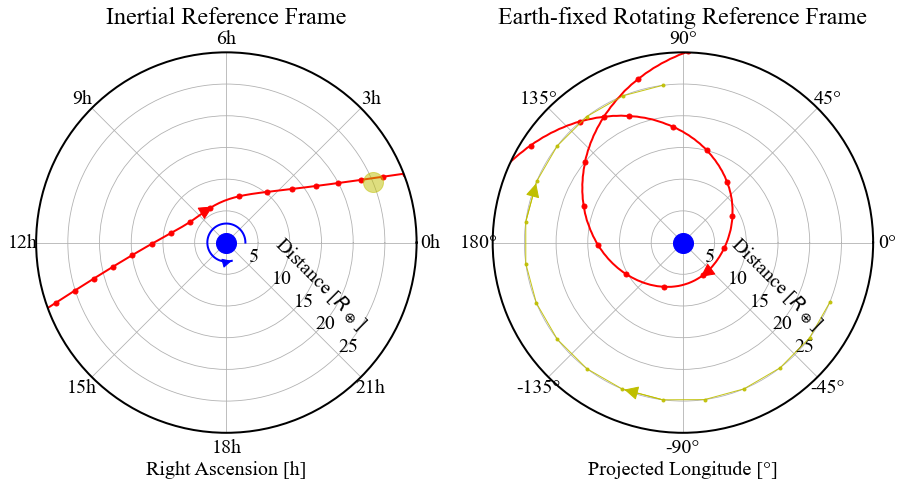

In [77]:
def get_lon(TIME,RA):
  """
  Gets the longitude that will be under the asteroid at every moment
  """   
  T = Time(TIME,format='jd')
  G = T.sidereal_time('apparent', 'greenwich').to(u.deg)
  return RA - G.value

sun = get_lon(ephemeris['datetime_jd'][::12],1.5*15)
for i in range(len(sun)):
   if sun[i] < -180: sun[i] += 360

sun = np.deg2rad(sun)

fig, (ax1,ax2) = plt.subplots(1,2,subplot_kw={'projection': 'polar'},figsize=(15,8))

def polar(ax,key,ylabel,title):
    line = ax.plot(np.deg2rad(ephemeris[key]),ephemeris['delta (Rt)'],'r-',lw=2)[0]
    # draw circles at hour marks (every 12 data points)
    for i in range(6,len(ephemeris),12):
        ax.plot(np.deg2rad(ephemeris[key])[i],ephemeris['delta (Rt)'][i],'r.',ms=10)
        # ax.text(np.deg2rad(ephemeris[key])[i],ephemeris['delta (Rt)'][i],ephemeris['datetime_str'][i][-5:],size=16)

    
    ax.set_xlabel(ylabel)
    ax.set_yticks([5,10,15,20,25])
    ax.text(-1.4*np.pi/4,15,"Distance [$R_\oplus$]",rotation=-45)
    ax.set_ylim([0,30])
    ax.set_rlabel_position(315)
    if key == 'RA':
        ax.set_xticklabels([f"{s}h" for s in range(0,25,3)])
        arrow = rotation(ax,100,3,5)[0]
        add_arrow(arrow,size=20,position=4.95)
        ax.plot(np.deg2rad(1.5*15),25,'yo',ms=20, alpha=0.5)
    else:
        angle = lambda x: x if x<= 180 else x - 360
        ax.set_xticklabels([f"{angle(s)}°" for s in range(0,360,45)])
        N = len(sun)
        # for n in [0,N//2,N-1]:
        #     ax.plot(sun[n],25,'yo',ms=20, alpha=0.5)
        sun_path = ax.plot(sun,sun*0+25,'y.-', alpha=0.9, lw=1)[0]
        add_arrow(sun_path,size=30, position=np.pi)
        add_arrow(sun_path,size=30, position=-np.pi/2)


    ax.set_title(title)
    ax.plot(0,0,'bo',ms=20)
    add_arrow(line,size=30)

polar(ax1,'RA','Right Ascension [h]','Inertial Reference Frame')
polar(ax2,'Longitude',"Projected Longitude [°]",'Earth-fixed Rotating Reference Frame')

name = f"{FIGDIR}/distance"
plt.savefig(name+".pdf",bbox_inches='tight')

### Magnitude plot

JPL Visual magnitude data was not totally smooth, instead it was like a staircase, so we made a polynomial fit to generate the curve of visual magnitude of the asteroid.

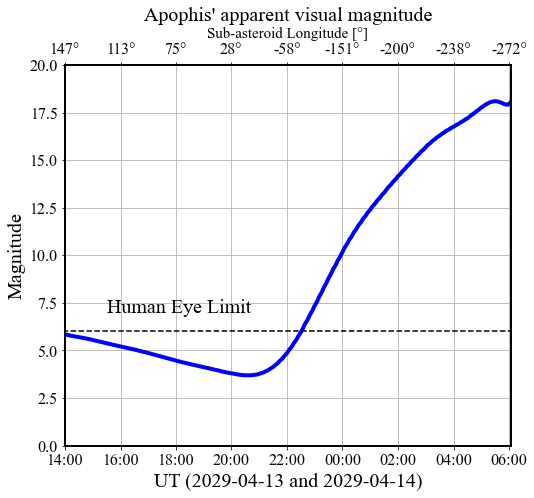

In [78]:
fig,ax = plt.subplots(figsize=(8,7))
ax.set_title(f"Apophis' apparent visual magnitude",size=20)

poly = np.polyfit(range(200),ephemeris['V'], deg=20)
p = np.poly1d(poly)
V = p(range(200))

ax.plot(ephemeris['hours'],V,'b-',lw=4)
ax.set_xlabel("UT (2029-04-13 and 2029-04-14)")
ax.set_ylabel("Magnitude")
ax.text(ephemeris['hours'][0]+2,7,"Human Eye Limit",size=20)
ax.grid()
xaxis()

secax = ax.secondary_xaxis('top')
secax.set_xlabel('Sub-asteroid Longitude [°]',size=15)

xticks = range(6,len(ephemeris),24)
secax.set_xticks([ephemeris['hours'][i] for i in xticks])
secax.set_xticklabels([f"{round(ephemeris['Longitude'][i])}°" for i in xticks], size=16)


plt.yticks(size=16)
plt.ylim([0,20])

plt.plot([-10,100],[6,6],'k--')

name = f"{FIGDIR}/magnitude"
plt.savefig(name+".pdf",bbox_inches='tight')
plt.savefig(name+".png",bbox_inches='tight')

### Observatory pairs

This section generates two plots showing the apparent elevation of the asteroid for all chosen antennae throughout the observation. The colors represent the observation stages. Some of the functions defined at the top were used to calculate the elevations.

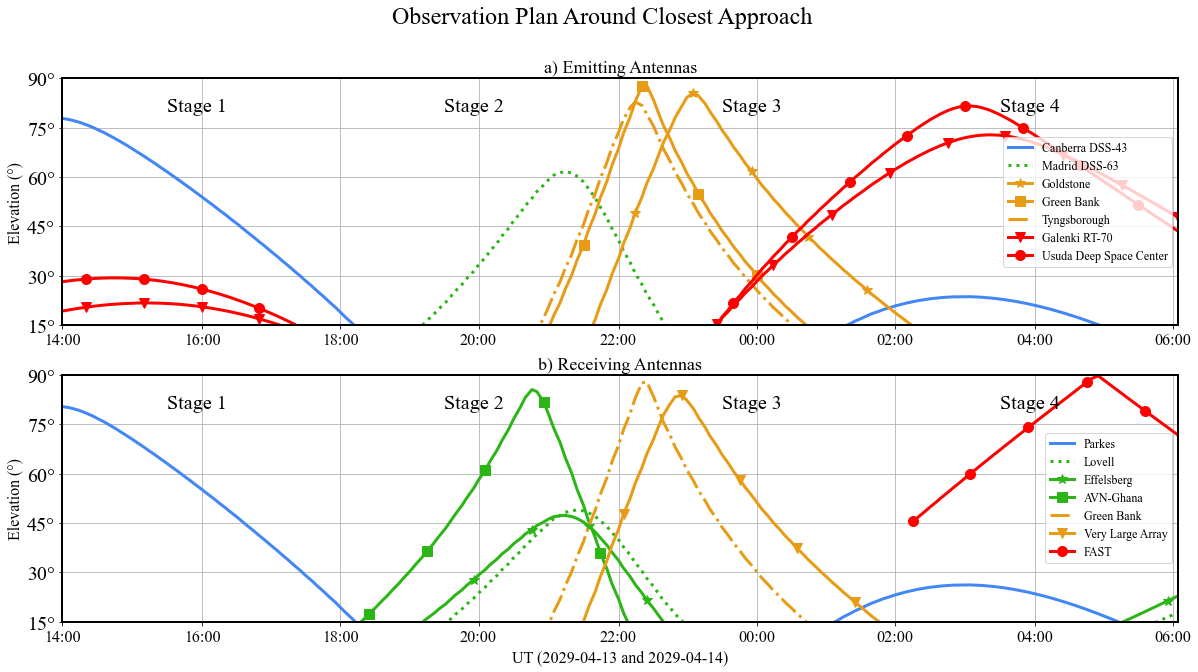

In [116]:
emitting = ['CDS','MDS','GOL','GBT','TYN','ECD','USU']
receiving = ['PRK','LOV','EFE','AVN','GBT','VLA','FAS']

emitting = [radio[radio.Code == a].iloc[0] for a in emitting]
receiving = [radio[radio.Code == a].iloc[0] for a in receiving]

def axes(ax,i):
    ax.set_ylim([15,90])
    ax.set_xlim([0,ephemeris['hours'].iloc[-1]])
    xticks = range(6,len(ephemeris),24)
    ax.set_xlim([ephemeris['hours'].iloc[6],ephemeris['hours'].iloc[-1]])
    ax.set_xticks([ephemeris['hours'][i] for i in xticks])
    yticks = list(range(15,91,15))
    ax.set_yticks(yticks)
    ax.set_yticklabels(["%i°"%h for h in yticks])
    ax.set_ylabel("Elevation (°)",size=16)
    ax.set_xticklabels([ephemeris['datetime_str'][i][-5:] for i in xticks],size=16)

    if i == 1:
        ax.set_xlabel("UT (2029-04-13 and 2029-04-14)",size=16)


fig, axs = plt.subplots(2,1, figsize=(20,10))
styles = ['-',':','*-','s-','-.','v-','o-','--','D-']
colors = ['#4287f5','#2bb516','#e89b15','#ff0000']

for i,antennae in enumerate([emitting,receiving]):
    ax = axs.flat[i]

    for j,obs1 in enumerate(antennae):
        cs = int(float(obs1.Stage)) - 1
        obs_data = single_elevation(obs1,ephemeris)

        visible = obs_data['elevation1'] > 0
        if obs1.Code == 'FAS':
            visible = obs_data['elevation1'] > 45

        ax.plot(ephemeris['hours'][visible],obs_data['elevation1'][visible],
            styles[j],label=f"{obs1['Name']}",lw=3,color=colors[cs],
            markevery=10, ms=10)
        # ax.plot(timesnt,Ynt,'--',lw=2,color='gray')
        axes(ax,i)

    for tt,t in enumerate(range(30,len(ephemeris),48)):
        ax.text(ephemeris['hours'][t]-0.5, 80, f"Stage {tt+1}")

    ax.legend(fontsize=12, loc="center right")
    ax.grid()

axs[0].set_title("a) Emitting Antennas",size=18)
axs[1].set_title("b) Receiving Antennas",size=18)

fig.suptitle("Observation Plan Around Closest Approach")

name = f"{FIGDIR}/observing-plan"
plt.savefig(name+".pdf",bbox_inches='tight')

### Visual observations in Teide

Generate elevation data for el Teide observatory, and create a plot in elevation and visual magnitude.

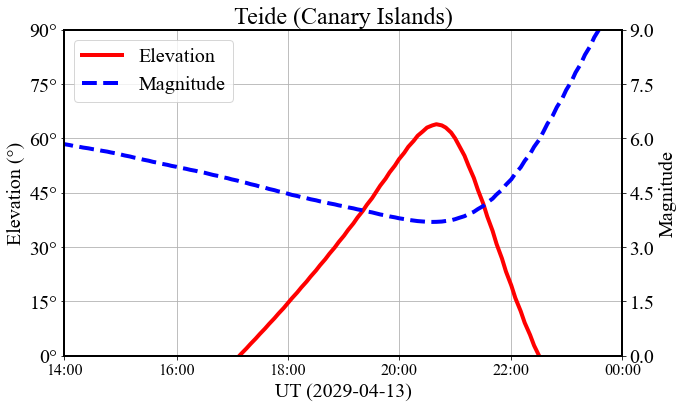

In [80]:
def axes(ax,i):
    ax.set_ylim([0,90])
    xticks = range(6,127,24)
    ax.set_xlim([ephemeris['hours'].iloc[6],ephemeris['hours'].iloc[126]])
    ax.set_xticks([ephemeris['hours'][i] for i in xticks])
    yticks = list(range(0,91,15))
    ax.set_yticks(yticks)
    ax.set_yticklabels(["%i°"%h for h in yticks])
    ax.set_ylabel("Elevation (°)")
    ax.set_xticklabels([ephemeris['datetime_str'][i][-5:] for i in xticks],size=16)

    ax.set_xlabel("UT (2029-04-13)")

teide = {
    "Name":"Teide",
    "Longitude":16.5,
    "Latitude":28.25
}


plt.figure(figsize=(10,6))
ax = plt.gca()

obs_data = single_elevation(teide,ephemeris)
line1= ax.plot(ephemeris['hours'],obs_data['elevation1'],'r-',label="Elevation",lw=4,markevery=10, ms=10)[0]
axes(ax,i)

ax2=ax.twinx()
line2 = ax2.plot(ephemeris['hours'],V,'b--',lw=4,label="Magnitude")[0]
ax2.set_ylabel("Magnitude")
# ax2.text(ephemeris['hours'][0]+1,7,"Human Eye Limit",size=20)
# plt.plot([-10,100],[6.5,6.5],'k--')
ax2.set_ylim([0,9])
ax2.set_yticks(np.arange(0,9.1,1.5))

ax.grid()
plt.legend(handles=[line1,line2])

plt.title("Teide (Canary Islands)")

name = f"{FIGDIR}/visual-teide"
plt.savefig(name+".pdf",bbox_inches='tight')
plt.savefig(name+".png",bbox_inches='tight')

### Time delay and Doppler shift

Load the observatories databases, as well as elevations and subradar points to calculate doppler frequency shift.

In [81]:
V = (np.array((vectors.vx,vectors.vy,vectors.vz))*(u.AU/u.d)).si
R = (np.array((vectors.x,vectors.y,vectors.z))*(u.AU)).si
R1 = R/np.linalg.norm(R, axis=0)

spherical = lambda lon,lat: (np.cos(np.deg2rad(lon))*np.cos(np.deg2rad(lat)),
                             np.sin(np.deg2rad(lon))*np.cos(np.deg2rad(lat)),
                             np.sin(np.deg2rad(lat)))

sphericalV = lambda lon,lat: (np.sin(np.deg2rad(lon))*np.cos(np.deg2rad(lat))*-1,
                              np.cos(np.deg2rad(lon))*np.cos(np.deg2rad(lat)),
                              0*lon)

norm = np.linalg.norm


def get_RA(TIME,LON):
  """
  Gets the longitude that will be under the asteroid at every moment
  """
  T = Time(TIME,format='jd')
  G = T.sidereal_time('apparent', 'greenwich').to(u.deg)
  return LON + G.value

import warnings
warnings.filterwarnings("ignore")

def get_dVr(obs):
    """
    Calculates the radial velocity between the asteroid and rotating earth
    """
    lon,lat = obs[['Longitude','Latitude']] # TX name from code
    RAs = get_RA(ephemeris.datetime_jd,lon)

    V_earth = (2*np.pi*c.R_earth/u.d)

    dV = (V - (sphericalV(RAs,lat)*V_earth).si)

    dVr = ddot(dV,R1)
    return dVr

def ddot(V1,V2):
    V3 = np.zeros_like(V1)
    for i in range(V3.shape[1]):
        V3[:,i] = np.dot(V1[:,i],V2[:,i])
    return norm(V3,axis=0)


def get_veph(code1,code2):
    """
    Calculates de Doppler Frequency Shift
    """
    obs1 = rtdb[rtdb.Code==code1].iloc[0]
    obs2 = rtdb[rtdb.Code==code2].iloc[0]

    F = obs1['Frequency']*1e6*u.Hz

    dVr1 = get_dVr(obs1)
    dVr2 = get_dVr(obs2)

    #return F*dVr1*dVr2/(c.c**2)
    return 2*F*dVr2/(c.c)

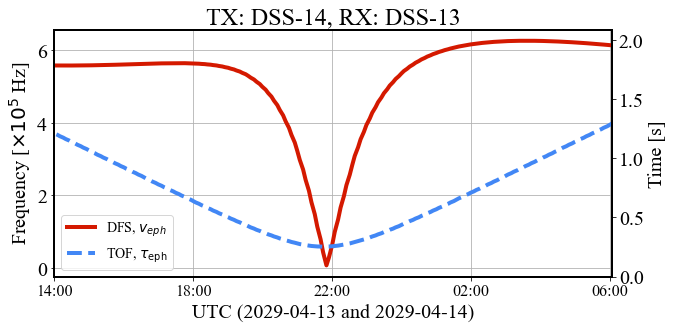

In [82]:
def x_axis(ax,i):
    ax.set_xlim([0,ephemeris['hours'].iloc[-1]])
    xticks = range(6,len(ephemeris),48)
    ax.set_xlim([ephemeris['hours'].iloc[6],ephemeris['hours'].iloc[-1]])
    ax.set_xticks([ephemeris['hours'][n] for n in xticks])

    if i != 10:
        ax.set_xticklabels([ephemeris['datetime_str'][i][-5:] for i in xticks],size=16)
        ax.set_xlabel("UTC (2029-04-13 and 2029-04-14)",size=20)
    else:
        ax.set_xticklabels([])

plt.figure(figsize=(10,10))

pairs2 = [
    ('GOL','GOL'),
    ('MDS','LOV'),
]

k = 1
for pair in pairs2[:-1]:
    if k == 1:
        plt.title("Doppler Frequency Shift \nand Time of flight")
    veph = get_veph(*pair)
    plt.subplot(2,1,k)
    ax = plt.gca()
    #lns1 = ax.semilogy(ephemeris['hours'],veph/1e5,label=r"DFS, $v_{eph}$",lw=4, color='#d41900')
    lns1 = ax.plot(ephemeris['hours'],veph/1e5,label=r"DFS, $v_{eph}$",lw=4, color='#d41900')
    x_axis(ax,k)
    ax.set_ylabel(r"Frequency [$\times 10^5$ Hz]")
    #ax.set_ylim([1e-3,1.5e1])
    ax.grid()
    ax2=plt.gca().twinx()
    lns2 = ax2.plot(ephemeris['hours'],2*ephemeris['delta (Rt)'] * c.R_earth / c.c, '--',
        label=r"TOF, $\tau_\mathrm{eph}$", lw=4, color='#4287f5')
    ax2.set_ylim([0,2.09])
    ax2.set_ylabel("Time [s]")

    lns = lns1+lns2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs,fontsize=14)
    k += 1

plt.title("TX: DSS-14, RX: DSS-13")
name = f"{FIGDIR}/TOF-DFS"
plt.savefig(name+".pdf",bbox_inches='tight')
plt.savefig(name+".png",bbox_inches='tight')

### Apparent rotation

Vectorial rotation equations were used along with the vector database to determine the apparent rotation of the asteroid as seen from Earth.

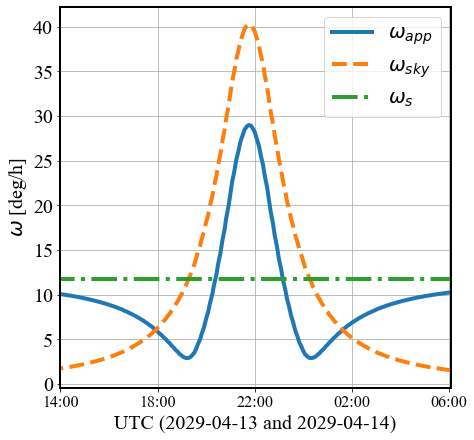

In [83]:
e = R1
e_dot = V/norm(R,axis=0) -  (norm(ddot(V,R1),axis=0)*R/(norm(R, axis=0)**2))
Wsky = np.cross(e_dot,e,axis=0).to(1/u.h)*180*u.deg/np.pi

W = spherical(118.8,-79.4)*(360*u.deg/(30.56*u.h))

WW = np.ones_like(Wsky)
for i in range(WW.shape[1]):
    WW[:,i] = W

Wapp = norm(WW+Wsky,axis=0)
WWW = norm(WW,axis=0)

plt.figure(figsize=(7,7))
plt.plot(ephemeris['hours'],Wapp,lw=4,label=r"$\omega_{app}$")
plt.plot(ephemeris['hours'],norm(Wsky,axis=0),'--',lw=4,label=r"$\omega_{sky}$")
plt.plot(ephemeris['hours'],WWW,'-.',lw=4,label=r"$\omega_s$")
plt.grid()
plt.legend()
x_axis(plt.gca(),0)
plt.ylabel(r"$\omega$ [deg/h]")

name = f"{FIGDIR}/rotation"
plt.savefig(name+".pdf",bbox_inches='tight')
plt.savefig(name+".png",bbox_inches='tight')

### Power

Uses observatory data and equations to calculate the transmission and reception power, to subsequently generate Ptx/Prx between observatory pairs.

In [84]:
def Gain(D,freq):
    lam=c.c/(freq)
    A=np.pi*(D/2)**2
    e=1
    G=4*np.pi*e*A/lam**2 # calculate gain (Eq. A)
    return G.cgs

def power(tx,rx,df,rtdb,dl,sig=0.023*u.km**2,tau=(0.1*u.s).cgs): # from literature
    nametx=rtdb.Name[rtdb.Code==tx].iloc[0] # TX name from code
    namerx=rtdb.Name[rtdb.Code==rx].iloc[0] # RX name from code
    rtx=(df[nametx].to_numpy())*c.R_earth # distance to TX
    rrx=(df[namerx].to_numpy())*c.R_earth # distance to RX
    Dtx=rtdb.Diameter[rtdb.Code==tx].iloc[0]*u.m # TX diameter
    Drx=rtdb.Diameter[rtdb.Code==rx].iloc[0]*u.m # RX diameter
    Tsys=rtdb.Tsys[rtdb.Code==rx].iloc[0]*u.K # system temperature (RX)
    freq=rtdb.Frequency[rtdb.Code==tx].iloc[0]*1e6*u.Hz # transmission freq TX
    Ptx=rtdb.Power[rtdb.Code==tx].iloc[0]*1e3*u.W # transmission power TX
    Gtx=Gain(Dtx,freq) # TX gain
    Grx=Gain(Drx,freq) # RX gain
    Prx=(Ptx*Gtx*Grx*(c.c/(freq))**2*sig/((4*np.pi)**3*rtx**2*rrx**2)).si # calculate Prx (Eq. B)
    PrxdB=10*np.log10((Prx/u.mW).si.value)  #return Prx in dBm
    Pratio=(Prx/Ptx).si  #return TX/RX power ratio

    SNRS = []

    lat=(dl.latR.to_numpy())*u.deg.to(u.rad) # sub-radar latitude to radians
    omega=(WWW.to(u.rad/u.s)) # dtheta/dt # angular frequency
    period=2*np.pi*u.rad/omega # return rotation period
    phi=lat # subradar latitude
    bw=2*np.cos(phi)*370*u.m*omega/((c.c/freq)) # Doppler bandwidth (Eq. C)
    Nrms=(Tsys*c.k_B*bw) # rms noise power (Eq. D)
    SNR=(Prx/Nrms).si # return signal-to-noise ratio
    SNRS.append(SNR)

    return PrxdB, Pratio, SNRS, omega, nametx,namerx

In [85]:
pairs = [
    ('CDS','PRK'),
    ('MDS','LOV'),
    ('MDS','AVN'),
    ('MDS','EFE'),
    ('G13','VLA'),
    ('G14','VLA'),
    ('G14','GBT'),
    ('GBT','VLA'),
    ('TYN','GBT'),
    ('ECD','FAS'),
    ('USU','FAS'),
]

CDS PRK
MDS LOV
MDS AVN
MDS EFE
G13 VLA
G14 VLA
G14 GBT
GBT VLA
TYN GBT
ECD FAS
USU FAS


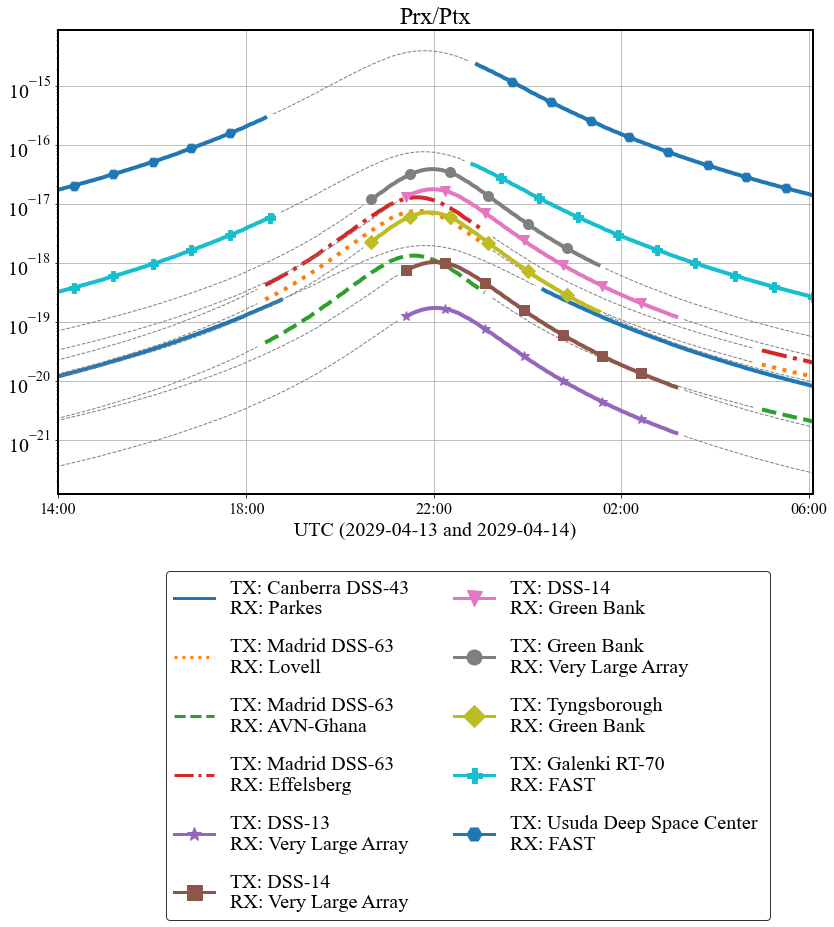

In [86]:
def x_axis(ax,i):
    ax.set_xlim([0,ephemeris['hours'].iloc[-1]])
    xticks = range(6,len(ephemeris),48)
    ax.set_xlim([ephemeris['hours'].iloc[6],ephemeris['hours'].iloc[-1]])
    ax.set_xticks([ephemeris['hours'][n] for n in xticks])

    if i != 10:
        ax.set_xticklabels([ephemeris['datetime_str'][i][-5:] for i in xticks],size=16)
        ax.set_xlabel("UTC (2029-04-13 and 2029-04-14)",size=20)
    else:
        ax.set_xticklabels([])


def chop(Ys, cond):
    """
    Removes the parts of an array which correspond to non visible zones
    """
    pm = np.array([a*b for a,b in zip(elevations[tx],elevations[tx][1:])])
    nanwhere = np.where(pm < 0)
    
    Y = Ys
    Y[nanwhere] = np.nan
    Y = Y[cond]
    return Y
    

def all_power_plots(axes,n,PrxdB, Pratio, SNR, nametx,namerx,df,tx,rx):
    title='TX: {} \nRX: {}'.format(nametx,namerx)

    savefigs = False
    styles = ['-',':','--','-.','*-','s-','v-','o-','D-','P-','H-']

    cond = elevations[tx] > 0
    times = ephemeris['hours'][cond]
    timesnt = ephemeris['hours'][~cond]

    Y = chop(PrxdB,cond)
    Ynt = chop(PrxdB,~cond)
    
    i = 0
    ax = axes

    # Power ratio plot
    Y = chop(Pratio,cond)
    Ynt = chop(Pratio,~cond)
    line,=ax.semilogy(times,Y,styles[n],lw=4,markevery=10,ms=10)
    ax.semilogy(timesnt,Ynt,'--',lw=1,color='gray')
    ax.set_title("Prx/Ptx")
    x_axis(ax,i)

    ax.plot([],[],styles[n],lw=3,markevery=10,ms=15,label=title,color=line.get_color())
    x_axis(ax,i)

import matplotlib
matplotlib.rc('ytick', labelsize=20) 
fig, axes = plt.subplots(1,1,figsize=(12,8))

n = 0
for tx, rx in pairs:
    print(tx,rx)
    PrxdB, Pratio, SNR, period, nametx, namerx = power(tx,rx,df,radio,dl)
    all_power_plots(axes, n, PrxdB, Pratio, SNR, nametx, namerx, df, tx, rx)
    n += 1

ax=axes
ax.grid()

handles,labels=axes.get_legend_handles_labels()
fig.legend(handles, labels, ncol=2, 
           bbox_to_anchor=(1,0,-0.08,0),
           fontsize=20,labelspacing=1,fancybox=True, edgecolor=(0,0,0))
fig.tight_layout()

name = f"{FIGDIR}/Prx_Ptx"
plt.savefig(name+".pdf",bbox_inches='tight')
plt.savefig(name+".png",bbox_inches='tight')

In [87]:
def Gain(D,freq):
    lam=c.c/(freq)
    A=np.pi*(D/2)**2
    e=1
    G=4*np.pi*e*A/lam**2 # calculate gain (Eq. A)
    return G.cgs

def power(tx,rx,df,rtdb,dl,sig=0.023*u.km**2,tau=(0.001*u.s).cgs): # from literature
    nametx=rtdb.Name[rtdb.Code==tx].iloc[0] # TX name from code
    namerx=rtdb.Name[rtdb.Code==rx].iloc[0] # RX name from code
    rtx=(df[nametx].to_numpy())*c.R_earth # distance to TX
    rrx=(df[namerx].to_numpy())*c.R_earth # distance to RX
    Dtx=rtdb.Diameter[rtdb.Code==tx].iloc[0]*u.m # TX diameter
    Drx=rtdb.Diameter[rtdb.Code==rx].iloc[0]*u.m # RX diameter
    Tsys=rtdb.Tsys[rtdb.Code==rx].iloc[0]*u.K # system temperature (RX)
    freq=rtdb.Frequency[rtdb.Code==tx].iloc[0]*1e6*u.Hz # transmission freq TX
    Ptx=rtdb.Power[rtdb.Code==tx].iloc[0]*1e3*u.W # transmission power TX
    Gtx=Gain(Dtx,freq) # TX gain
    Grx=Gain(Drx,freq) # RX gain
    Prx=(Ptx*Gtx*Grx*(c.c/(freq))**2*sig/((4*np.pi)**3*rtx**2*rrx**2)).si # calculate Prx (Eq. B)
    PrxdB=10*np.log10((Prx/u.mW).si.value)  #return Prx in dBm
    Pratio=(Prx/Ptx).si  #return TX/RX power ratio

    SNRS = []
    
    D=370*u.m

    lat=(dl.latR.to_numpy())*u.deg.to(u.rad) # sub-radar latitude to radians
    omega=(Wapp.to(u.rad/u.s)) # dtheta/dt # angular frequency
    period=2*np.pi*u.rad/omega # return rotation period
    phi=lat # subradar latitude
    bw=2*D*np.cos(phi)*omega/((c.c/freq)) # Doppler bandwidth (Eq. C)
    Nrms=(Tsys*c.k_B*bw) # rms noise power (Eq. D)
    SNR=(Prx/Nrms).si # return signal-to-noise ratio
    SNRS.append(SNR)

    lat=(dl.latR.to_numpy())*u.deg.to(u.rad) # sub-radar latitude to radians
    omega=(WWW.to(u.rad/u.s)) # dtheta/dt # angular frequency
    period=2*np.pi*u.rad/omega # return rotation period
    phi=lat # subradar latitude
    bw=2*D*np.cos(phi)*omega/((c.c/freq)) # Doppler bandwidth (Eq. C)
    Nrms=(Tsys*c.k_B*bw) # rms noise power (Eq. D)
    SNR=(Prx/Nrms).si # return signal-to-noise ratio
    SNRS.append(SNR)

    return PrxdB, Pratio, SNRS, omega, nametx,namerx

### SNR

Calculates the Signal to Noise Ratio of the selected observatory pairs.

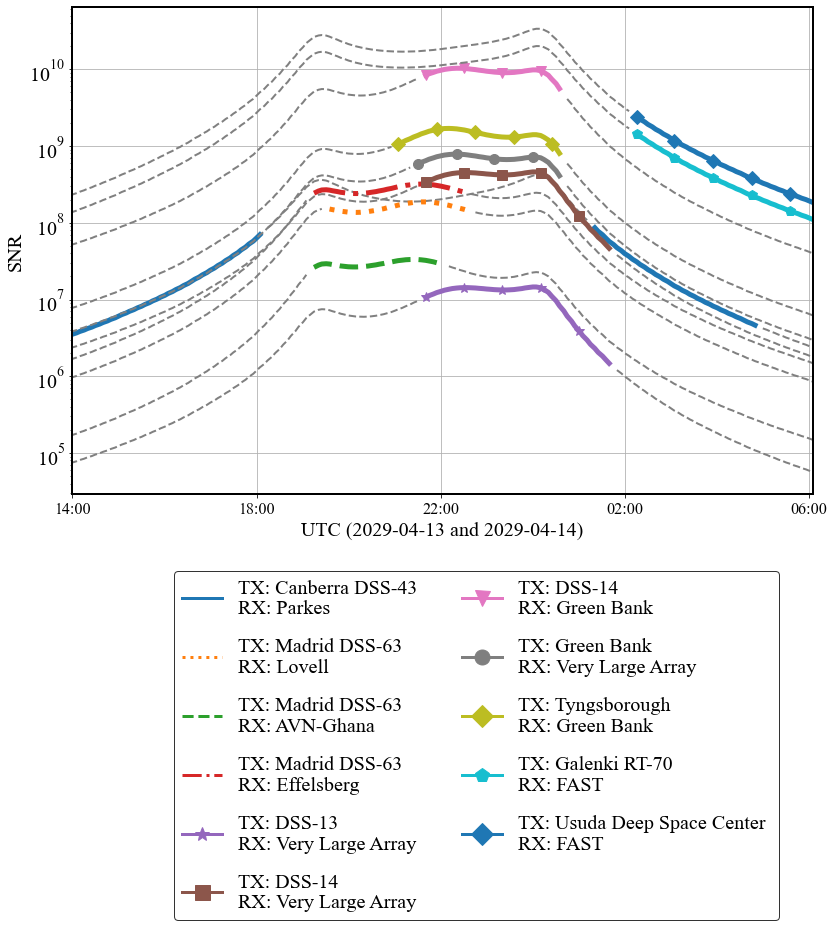

In [118]:
def x_axis(ax,i):
    ax.set_xlim([0,ephemeris['hours'].iloc[-1]])
    xticks = range(6,len(ephemeris),48)
    ax.set_xlim([ephemeris['hours'].iloc[6],ephemeris['hours'].iloc[-1]])
    ax.set_xticks([ephemeris['hours'][n] for n in xticks])

    if i != 10:
        ax.set_xticklabels([ephemeris['datetime_str'][i][-5:] for i in xticks],size=16)
        ax.set_xlabel("UTC (2029-04-13 and 2029-04-14)",size=20)
    else:
        ax.set_xticklabels([])


def chop(Ys, cond):
    """
    Removes the parts of an array which correspond to non visible zones.
    cond is the condition array (T or F), pm is the sum of one and the next
    element of cond. In the index where it changes from T to F, the sum is 1.

    Add a np.nan there to discontinue the line
    """
    pm = np.array([a+b for a,b in zip(cond,cond[1:])])
    nanwhere = np.where(pm == 1)

    
    Y = Ys
    Y[nanwhere] = np.nan
    Y = Y[cond]
    return Y

def all_power_plots(axes,n,PrxdB, Pratio, SNR, nametx,namerx,df,tx,rx):
    title='TX: {} \nRX: {}'.format(nametx,namerx)

    savefigs = False
    styles = ['-',':','--','-.','*-','s-','v-','o-','D-','p-','D-']

    cond = (elevations[tx] > 15) * (elevations[rx] > 15)
    if rx == 'FAS':
        cond = cond * (elevations[rx] > 45)

    times = ephemeris['hours'][cond]
    timesnt = ephemeris['hours'][~cond]

    # Y = chop(PrxdB,cond)
    # Ynt = chop(PrxdB,~cond)
    
    i=0
    # ax = axes[1]

    # # SNR plot
    SNR,SNR2 = SNR

    # Y = chop(SNR,cond)
    # Ynt = chop(SNR,~cond)
    # # ax.semilogy(ephemeris['hours'],SNR,styles[n],lw=3,markevery=10,ms=10)
    # line,=ax.semilogy(times,Y/Y0,styles[n],lw=3,markevery=10,ms=10)
    # ax.semilogy(timesnt,Ynt/Y0,'--',lw=1,color='gray')
    # ax.set_ylabel(r"SNR/SNR$_{GDSS}$")
    # x_axis(ax,i)

    # i += 1
    ax = axes

    # Y2 = chop(SNR2,cond)
    Y = chop(SNR,cond)
    Ynt = chop(SNR,~cond)
    line,=ax.semilogy(times,Y,styles[n],lw=5,markevery=10,ms=10)
    # ax.semilogy(times,Y2,'*--',lw=5,markevery=10,ms=10,color='red')
    ax.semilogy(timesnt,Ynt,'--',lw=2,color='gray')
    # ax.set_title("TX: DSS-14, RX: DSS-13")
    ax.set_ylabel(r"SNR")
    #ax.legend()
    x_axis(ax,i)


    # rotation period plot
    ax.plot([],[],styles[n],lw=3,markevery=10,ms=15,label=title,color=line.get_color())
    # ax.set_ylabel("Angular frequency (deg/hour)")
    # ax.legend(fontsize=15)
    x_axis(ax,i)


fig, axes = plt.subplots(1,1,figsize=(12,8))

n = 0
for tx, rx in pairs:
    PrxdB, Pratio, SNR, period, nametx,namerx= power(tx,rx,df,rtdb,dl)
    all_power_plots(axes, n, PrxdB, Pratio, SNR, nametx, namerx, df, tx, rx)
    n += 1

axes.grid()

handles, labels = axes.get_legend_handles_labels()
fig.legend(handles, labels, ncol=2, 
           bbox_to_anchor=(1,0,-0.07,0),
           fontsize=20,labelspacing=1,fancybox=True, edgecolor=(0,0,0))
fig.tight_layout()
name = f"{FIGDIR}/SNR"
plt.savefig(name+".pdf",bbox_inches='tight')
plt.savefig(name+".png",bbox_inches='tight')

### Surface coverage

Generates a synthetic surface coordinate system for Apophis, and calculates how much of the surface is covered from each radio observatory pair.

In [90]:
# Obtains the Astropy Position Vector of given earth coordinates
pos = lambda x,h: EarthLocation(lon=x['Longitude']*u.deg,lat=x['Latitude']*u.deg,height=h*u.earthRad)

# Transforms an Astropy object into a simple 3-tuple vector
vec = lambda a:  (a.x.value,
                  a.y.value,
                  a.z.value)

# Returns the magnitude of a vector
dist = lambda v: np.linalg.norm(v)

# Returns the angle between two vectors in degrees
angle = lambda v1,v2: np.rad2deg( np.arccos( np.dot(v1,v2) / (dist(v1) * dist(v2)) ) )

def zenith_ecuat(obs, obs_time):
    """
    Obtains the coordinates of the observer's zenith at obs_time (jd)
    """
    zenith = SkyCoord(az=0*u.deg, alt=90*u.deg, distance=1*u.earthRad,
                      location=pos(obs,0), obstime=Time(obs_time, format='jd'), frame='altaz')
    return zenith.gcrs

def get_apo_to_earth(apo,obs,only_visible=True):
    """
    This function outputs the coordinates of an observatory as seen by Apophis.
    only_visible: If True, only returns points unobstructed by earth, invisible ones are None.
    If False, return all points.
    """
    # Apophis' coordinates
    apo_sky = SkyCoord(ra=apo['RA']*u.deg,dec=apo['DEC']*u.deg,
                       distance=apo['delta (Rt)']*u.earthRad)
    obs_time = Time(apo['datetime_jd'], format='jd')
    if (obs is None):
        apo_to_obs = SkyCoord(-apo_sky.cartesian, frame='gcrs', obstime=obs_time)
    else:
        obs_zenith = zenith_ecuat(obs, obs_time)
        # Dot product to determine if there's visibility:
        dot = np.dot(vec(apo_sky.cartesian),vec(obs_zenith.cartesian))
        if only_visible and dot < 0:
            return None
        apo_to_obs = SkyCoord(obs_zenith.cartesian - apo_sky.cartesian, frame='gcrs', obstime=obs_time)
    return apo_to_obs

def new_coordinates_matrix():
    """
    Generates a rotation matrix with respect to Apophís moment of intertia
    https://ned.ipac.caltech.edu/coordinate_calculator?in_csys=Ecliptic&in_equinox=J2000.0&obs_epoch=2000.0&lon=250&lat=-75&pa=0.0&out_csys=Equatorial&out_equinox=J2000.0
    https://www.aanda.org/articles/aa/pdf/2018/09/aa32914-18.pdf
    """
    # NEW Z AXIS
    new_z = SkyCoord(ra=118.79*u.deg,dec=-79.4*u.deg,
                       distance=1*u.earthRad)
    new_z = vec(new_z.cartesian)
    new_z /= np.linalg.norm(new_z)

    # NEW X AXIS
    new_x = SkyCoord(ra=0*u.deg,dec=0*u.deg,
                       distance=1*u.earthRad)
    new_x = vec(new_x.cartesian)
    new_x = np.cross(new_z,new_x)
    new_x /= np.linalg.norm(new_x)

    # NEW Y AXIS
    new_y = np.cross(new_z,new_x)
    new_y /= np.linalg.norm(new_y)

    ROT = np.matrix([new_x,new_y,new_z])
    return ROT

def to_asteroid_coordinates(v_gcrs,t):
    """
    Gets a vector in gcrs representation and generates the
    Asteroid local coordinates for a given time t.

    Asteroid coordinates are based on the axis of rotation.
    """
    v_subradar = to_subradar_coordinates(v_gcrs)
    v_subradar_rotated = rotate_asteroid(v_subradar,t)
    return v_subradar_rotated

def to_subradar_coordinates(v_gcrs):
    """
    Gets a vector in gcrs representation and generates the
    Asteroid local coordinates for a time 0.
    """
    ROT = new_coordinates_matrix()
    v_subradar = np.matmul(ROT,vec(v_gcrs.cartesian))
    v_subradar = np.array(v_subradar).flatten()
    return SkyCoord(*v_subradar,representation_type='cartesian').gcrs

def rotate_asteroid(v_subradar,t):
    ROT = rotation_matrix(t)
    v_subradar_rotated = np.matmul(ROT,vec(v_subradar.cartesian))
    v_subradar_rotated = np.array(v_subradar_rotated).flatten()
    return SkyCoord(*v_subradar_rotated,representation_type='cartesian').gcrs

def rotation_matrix(t):
    omega = 2*np.pi/(27.38/24)
    theta = omega*t - 0.5967
    ROT = np.matrix([[np.cos(theta),np.sin(theta),0],
                     [-np.sin(theta),np.cos(theta),0],
                     [0,0,1]])
    return ROT

def get_subradar_points(ephemeris,obs,only_visible=True):
    """
    This function iterates over the ephemeris to generate subradar points 
    for a specific observatory
    """
    output = {"date":[],
              "date_jd": [],
              "ra":[],
              "dec":[],
              "lon":[],
              "lat":[],
              "latR":[],
              "lonR":[],
              "dist":[]}

    date0 = ephemeris['datetime_jd'][ephemeris['delta (Rt)'].idxmin()]
    for r,row in ephemeris.iterrows():
        point = get_apo_to_earth(row,obs,only_visible)
        if point:
            point_sub = to_subradar_coordinates(point)
            output['date'] += [row['datetime_str']]
            output['date_jd'] += [row['datetime_jd']]

            # ECUATORIAL COORDINATES OF OBSERVATORY FROM APOPHIS
            output['ra']   += [point.ra.value]
            output['dec']  += [point.dec.value]

            # LOCAL COORDINATES OF OBS FROM APOPHIS
            output['lat']  += [point_sub.dec.value]
            if point_sub.ra.value < 180:
                output['lon'] += [point_sub.ra.value]
            else:
                output['lon'] += [point_sub.ra.value - 360]

            # LOCAL COORDINATES OF OBS FROM APOPHIS APPLYING ROTATION
            t = row['datetime_jd'] - date0
            point_sub_rotated = rotate_asteroid(point_sub,t)
            output['latR']  += [point_sub_rotated.dec.value]
            if point_sub_rotated.ra.value < 180:
                output['lonR'] += [point_sub_rotated.ra.value]
            else:
                output['lonR'] += [point_sub_rotated.ra.value - 360]

            output['dist'] += [row['delta (Rt)']]
    return output

In [91]:
def path(ax):
    ax.plot(np.deg2rad(subradar_points.lonR),np.deg2rad(subradar_points.latR),'ko',ms=7)
    ax.plot(np.deg2rad(subradar_points.lonR),np.deg2rad(subradar_points.latR),'wo',ms=6)

def earth(ax,t):
    ax.plot(np.deg2rad(subradar_points.lonR[t]),np.deg2rad(subradar_points.latR[t]),'bo',ms=17)
    ax.plot(np.deg2rad(subradar_points.lonR[t]),np.deg2rad(subradar_points.latR[t]),'wo',ms=12)
    ax.plot(np.deg2rad(subradar_points.lonR[t]),np.deg2rad(subradar_points.latR[t]),'b_',ms=17)
    ax.plot(np.deg2rad(subradar_points.lonR[t]),np.deg2rad(subradar_points.latR[t]),'b|',ms=17)

In [92]:
radio.Code

plan = ['PRK','AVN','GBT','FAS']

plan = [radio[radio.Code == a].iloc[0] for a in plan]# Given longitude and latitude angles in degrees, return cartesian representation
spherical = lambda lon,lat: (np.cos(np.deg2rad(lon))*np.cos(np.deg2rad(lat)),
                             np.sin(np.deg2rad(lon))*np.cos(np.deg2rad(lat)),
                             np.sin(np.deg2rad(lat)))

sphericalV = lambda lon,lat: (np.sin(np.deg2rad(lon))*np.cos(np.deg2rad(lat))*-1,
                              np.cos(np.deg2rad(lon))*np.cos(np.deg2rad(lat)),
                              0*lon)

N_lons = 72
N_lats = 36
lons   = np.linspace(-180,180,N_lons)
lats   = np.linspace(-90,90,N_lats)

lon_grid, lat_grid = np.meshgrid(lons, lats)

def coverage(point):
    """
    Returns the meshgrid of all the radar coverage
    """
    out = np.zeros((N_lats,N_lons))
    dot = np.tensordot(spherical(point.lonR, point.latR),
                    spherical(lon_grid, lat_grid), axes=1)
    out[dot > 0] = 1
    return out

def full_coverage(subradar_points):
    out = np.zeros((N_lats,N_lons))
    for r, point in subradar_points.iterrows():
        out += coverage(point)
    out /= np.max(out)
    return out

def radial_coverage(point):
    """
    Returns the meshgrid of all the radar coverage
    """
    out = coverage(point)
    dotV = np.tensordot(spherical(point.lonR, point.latR),
                sphericalV(lon_grid, lat_grid), axes=1)
    return out*dotV*20 # 1e-3 m/s

def minmax(arr):
    arrmax = np.max(arr,axis=0)
    arrmin = np.min(arr,axis=0)

    out = arrmax
    out[arrmax < np.abs(arrmin)] = arrmin[arrmax < np.abs(arrmin)]

    return out


def full_coverage_radial(subradar_points):
    out = np.zeros((len(ephemeris),N_lats,N_lons))
    for r, point in subradar_points.iterrows():
        out[r] = radial_coverage(point)
    out = minmax(out)
    # out = np.max(out,axis=0) - np.min(out,axis=0)
    # out = out[MIN]
    return out


subradar_points = pd.DataFrame(get_subradar_points(ephemeris,None))

MIN = subradar_points['dist'].argmin()
full_cov_all = full_coverage_radial(subradar_points)
full_cov = np.mean(full_cov_all)

In [70]:
all_integrable = np.zeros((N_lats,N_lons))

for obs in plan:
    subradar_points = pd.DataFrame(get_subradar_points(ephemeris,obs))
    full_cov = full_coverage(subradar_points)
    # full_cov_h = full_cov_norm*total_time
    # integrable = np.vectorize(covered)(full_cov_h)
    all_integrable += full_cov

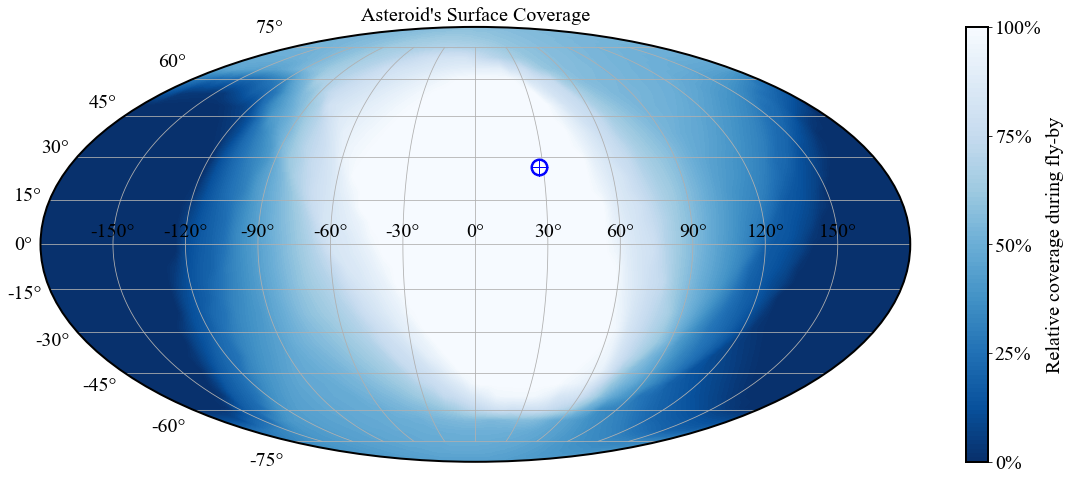

In [71]:
fig = plt.figure(figsize=(20,8))
ax = plt.subplot(111, projection = 'mollweide')
ax.set_title("Asteroid's Surface Coverage",size=20)
axx = ax.contourf(np.deg2rad(lons), np.deg2rad(lats), all_integrable/4, cmap="Blues_r", levels=100)

# ax.plot(np.deg2rad(subradar_points.lonR),np.deg2rad(subradar_points.latR),'ko',ms=7)
# ax.plot(np.deg2rad(subradar_points.lonR),np.deg2rad(subradar_points.latR),'wo',ms=6)

ax.plot(np.deg2rad(subradar_points.lonR[MIN]),np.deg2rad(subradar_points.latR[MIN]),'bo',ms=17)
ax.plot(np.deg2rad(subradar_points.lonR[MIN]),np.deg2rad(subradar_points.latR[MIN]),'wo',ms=12)
ax.plot(np.deg2rad(subradar_points.lonR[MIN]),np.deg2rad(subradar_points.latR[MIN]),'b_',ms=17)
ax.plot(np.deg2rad(subradar_points.lonR[MIN]),np.deg2rad(subradar_points.latR[MIN]),'b|',ms=17)
ax.grid()

cbar = fig.colorbar(axx, label="Relative coverage during fly-by")
cbar.set_ticks([0, .25, .5, .75, 1])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])

name = f"{FIGDIR}/coverage"
plt.savefig(name+".pdf",bbox_inches='tight')
plt.savefig(name+".png",bbox_inches='tight')